# Prognozowanie szeregów czasowych w PyTorch (LSTM)

W tym notatniku tworzymy prosty przykład prognozowania szeregów czasowych metodą uczenia nadzorowanego.

- Generujemy syntetyczny szereg czasowy (sinus + trend + szum).
- Tworzymy z niego próbki typu sekwencja->następna próbka (sequence-to-one).
- Budujemy i trenujemy model LSTM (`nn.LSTM`) w PyTorch.
- Oceniamy jakość prognoz i wizualizujemy wyniki.

W porównaniu do prostego `nn.RNN`, `nn.LSTM` lepiej radzi sobie z dłuższymi zależnościami czasowymi dzięki mechanizmowi komórki pamięci (cell state) i bramkom.

In [1]:
# Importy
import math
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Ustawienia i deterministyczność
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## 1. Generowanie i wizualizacja danych
Tworzymy sztuczny szereg czasowy: sinus o wolno zmieniającej się częstotliwości + trend liniowy + szum gaussowski.

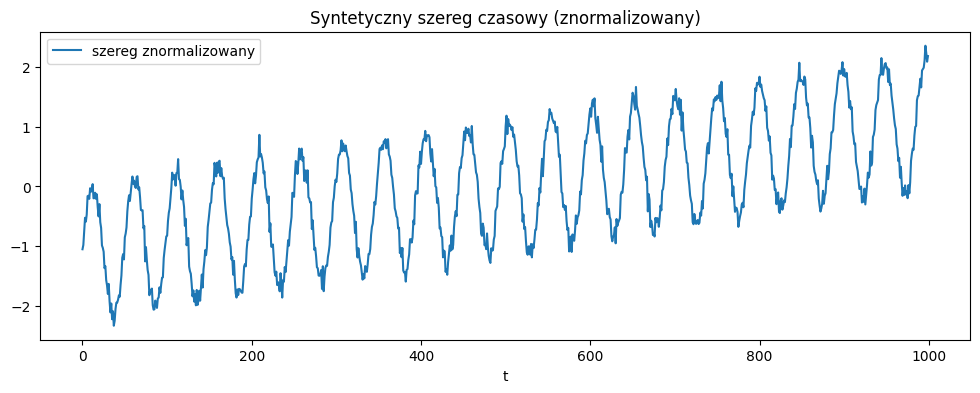

(array([-1.0482155 , -0.97648875, -0.75217397, -0.52259769, -0.58652932]),
 1.011556278099109,
 0.9176403615489072)

In [2]:
# Parametry szeregu
N = 1000             # liczba punktów
trend = 0.002        # nachylenie trendu
noise_std = 0.1      # odchylenie standardowe szumu

t = np.arange(N)
# Sinus z delikatną modulacją częstotliwości
x = np.sin(2 * np.pi * t / 50.0 + 0.002*t)
x += trend * t
x += np.random.normal(0, noise_std, size=N)

# Normalizacja (standaryzacja)
mu, sigma = x.mean(), x.std()
x_norm = (x - mu) / (sigma + 1e-8)

plt.figure(figsize=(12,4))
plt.plot(t, x_norm, label='szereg znormalizowany')
plt.title('Syntetyczny szereg czasowy (znormalizowany)')
plt.xlabel('t')
plt.legend()
plt.show()

x_norm[:5], mu, sigma

## 2. Tworzenie próbek sekwencyjnych (okna czasowe)
Z sekwencji tworzymy przykłady (wejście, wyjście), gdzie wejściem jest okno o długości `SEQ_LEN`, a wyjściem kolejna próbka (one-step ahead).

In [3]:
SEQ_LEN = 40

def create_sequences(series: np.ndarray, seq_len: int):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y

X_all, y_all = create_sequences(x_norm, SEQ_LEN)
X_all.shape, y_all.shape

((960, 40), (960,))

## 3. Podział na zbiory treningowy i testowy + DataLoader
Użyjemy ostatnich 20% danych jako test.

In [4]:
split_idx = int(0.8 * len(X_all))
X_train, y_train = X_all[:split_idx], y_all[:split_idx]
X_test, y_test = X_all[split_idx:], y_all[split_idx:]

class SeqDataset(Dataset):
    def __init__(self, X, y):
        # LSTM w PyTorch może przyjmować wejście (seq_len, batch, input_size) lub (batch, seq_len, input_size) z batch_first=True.
        # My będziemy trzymać (batch, seq_len, 1) i permutować w modelu.
        self.X = torch.tensor(X, dtype=torch.float32)  # (N, seq_len)
        self.y = torch.tensor(y, dtype=torch.float32)  # (N,)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Dodajemy wymiar input_size=1 dla każdego kroku czasowego
        return self.X[idx].unsqueeze(-1), self.y[idx]  # (seq_len, 1), ()

train_ds = SeqDataset(X_train, y_train)
test_ds = SeqDataset(X_test, y_test)

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)
len(train_ds), len(test_ds)

(768, 192)

## 4. Model LSTM w PyTorch
Użyjemy architektury: `nn.LSTM` -> `nn.Linear` (mapującej ostatni stan ukryty na prognozę).

In [5]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, dropout=0.0, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
            batch_first=False
        )
        self.num_directions = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * self.num_directions, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size) -> permute to (seq_len, batch, input_size)
        x = x.permute(1, 0, 2)
        out_seq, (h_n, c_n) = self.lstm(x)
        # out_seq: (seq_len, batch, hidden*directions)
        # We use the output at the last time step:
        last_hidden_out = out_seq[-1]  # (batch, hidden*directions)
        out = self.fc(last_hidden_out)  # (batch, 1)
        return out.squeeze(-1)          # (batch,)

model = LSTMRegressor(hidden_size=64).to(device)
model

LSTMRegressor(
  (lstm): LSTM(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## 5. Trening
Trenujemy model w celu minimalizacji MSE pomiędzy prognozowanym a rzeczywistym następnym punktem szeregu.

Epoch   1 | train MSE: 0.7676 | val MSE: 1.1174
Epoch   5 | train MSE: 0.0576 | val MSE: 0.1415
Epoch  10 | train MSE: 0.0221 | val MSE: 0.0340
Epoch  15 | train MSE: 0.0198 | val MSE: 0.0262
Epoch  20 | train MSE: 0.0193 | val MSE: 0.0277
Epoch  25 | train MSE: 0.0202 | val MSE: 0.0270
Epoch  30 | train MSE: 0.0186 | val MSE: 0.0226
Epoch  35 | train MSE: 0.0187 | val MSE: 0.0248
Epoch  40 | train MSE: 0.0179 | val MSE: 0.0254


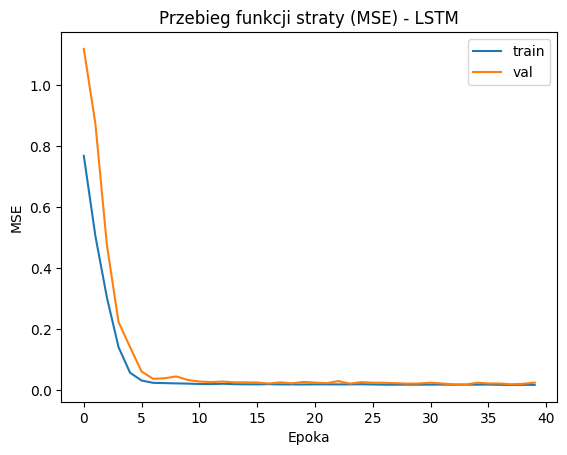

In [6]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
EPOCHS = 40

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        # xb: (batch, seq_len, 1)
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)

    epoch_loss /= len(train_ds)
    train_losses.append(epoch_loss)

    # Walidacja na teście (one-step)
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            vloss += loss.item() * xb.size(0)
        vloss /= len(test_ds)
        val_losses.append(vloss)

    if epoch % 5 == 0 or epoch == 1:
        print(f'Epoch {epoch:3d} | train MSE: {epoch_loss:.4f} | val MSE: {vloss:.4f}')

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('Przebieg funkcji straty (MSE) - LSTM')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 6. Ewaluacja: prognoza rekurencyjna na zbiorze testowym
W prognozowaniu wielokrokowym często stosuje się podejście rekurencyjne:
- Startujemy od ostatniego okna ze zbioru treningowego,
- przewidujemy kolejny punkt,
- dołączamy go do okna i usuwamy najstarszy element,
- powtarzamy dla całej długości zbioru testowego.

Poniżej wizualizujemy wynik na oryginalnej skali (odwracamy normalizację).

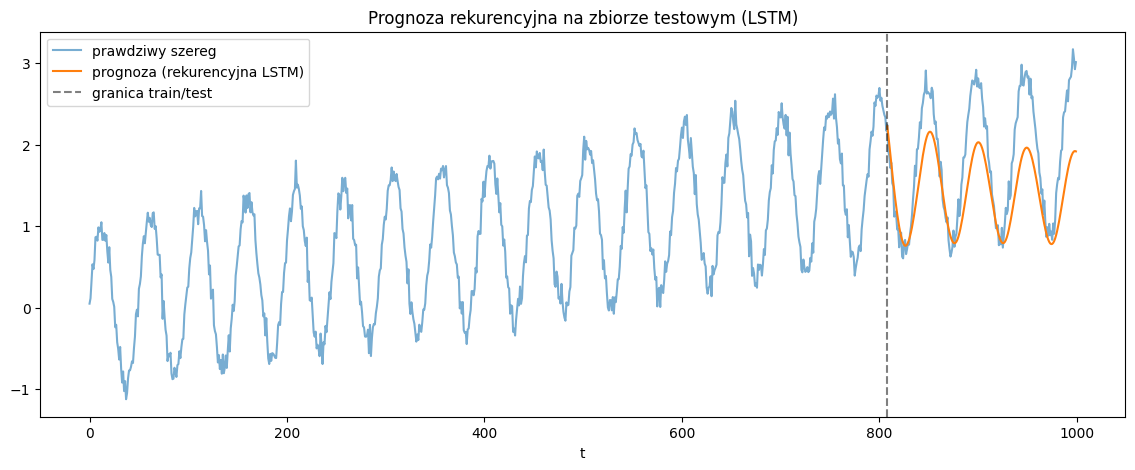

MSE (rekurencyjna prognoza vs. y_test, skala znormalizowana): 0.359


In [7]:
# Odwracanie normalizacji

def denorm(z):
    return z * (sigma + 1e-8) + mu

# Początkowe okno: ostatnie okno ze zbioru treningowego (w oryginalnej znormalizowanej skali)
start_idx = split_idx  # indeks pierwszego punktu testowego w danych okienkowych
init_window = X_all[start_idx-1]  # okno poprzedzające pierwszy punkt testowy

# Rekurencyjna prognoza na długość testu
model.eval()
window = torch.tensor(init_window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)  # (1, seq_len, 1)
preds_test = []
with torch.no_grad():
    for _ in range(len(y_test)):
        yhat = model(window).item()            # skala znormalizowana
        preds_test.append(yhat)
        # Przesuwamy okno: usuwamy najstarszy, dodajemy nową prognozę
        next_step = torch.tensor([[yhat]], dtype=torch.float32, device=device)  # (1,1)
        window = torch.cat([window[:, 1:, :], next_step.unsqueeze(1)], dim=1)

# Przygotowanie do wizualizacji
true_test_denorm = denorm(y_test)
preds_test_denorm = denorm(np.array(preds_test))

plt.figure(figsize=(14,5))
plt.plot(denorm(x_norm), label='prawdziwy szereg', alpha=0.6)
# Zakres indeksów dla przewidywań testowych w oryginalnej osi czasu
test_time_index = np.arange(split_idx + SEQ_LEN, split_idx + SEQ_LEN + len(preds_test_denorm))
plt.plot(test_time_index, preds_test_denorm, label='prognoza (rekurencyjna LSTM)')
plt.axvline(split_idx + SEQ_LEN, color='k', linestyle='--', alpha=0.5, label='granica train/test')
plt.title('Prognoza rekurencyjna na zbiorze testowym (LSTM)')
plt.xlabel('t')
plt.legend()
plt.show()

# Prosta metryka MSE na teście (porównując do prawdy one-step)
mse_recursive = np.mean((preds_test - y_test)**2)
print('MSE (rekurencyjna prognoza vs. y_test, skala znormalizowana):', round(float(mse_recursive), 4))

## 7. (Opcjonalnie) Zapis i odczyt wytrenowanego modelu
Najczęściej zapisujemy same wagi (`state_dict`).

In [8]:
save_path = 'lstm_timeseries_state_dict.pt'
torch.save(model.state_dict(), save_path)
print('Zapisano wagi do:', save_path)

# Załadowanie (przykład):
loaded = LSTMRegressor(hidden_size=64).to(device)
loaded.load_state_dict(torch.load(save_path, map_location=device))
loaded.eval()
print('Model LSTM wczytano poprawnie.')

Zapisano wagi do: lstm_timeseries_state_dict.pt
Model LSTM wczytano poprawnie.


## Podsumowanie
- Zbudowaliśmy prosty pipeline do prognozowania szeregów czasowych w PyTorch z użyciem `nn.LSTM`.
- Pokazaliśmy przygotowanie danych (okna czasowe), trening, walidację oraz prognozowanie rekurencyjne i wizualizację wyników.
- W praktyce warto eksperymentować z długością okna, rozmiarem warstw, liczbą warstw, bidirectional LSTM oraz dropoutem.